In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from scipy.interpolate import NearestNDInterpolator
from matplotlib import colors
import pandas as pd
import cv2
import scipy as sp
import rasterio
from rasterio.transform import Affine
from rasterio.merge import merge

In [2]:
def remove_cell_iso(mat,f,min_size=10):
    M=mat.copy()
    M[M!=f]=0
    labels=sp.ndimage.label(M)
    label_count=np.zeros(labels[-1]+1)
    for j in range(labels[-1]+1):
        label_count[j]=np.sum(labels[0]==j)
    mat[np.isin(labels[0],np.arange(labels[-1]+1)[label_count<min_size]) & np.equal(mat,f)]=np.nan
    return mat

In [3]:
cmap = colors.ListedColormap(['orange', 'forestgreen','sienna','gold','navy','darksalmon','lightblue'])
bounds=[0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5]
norm = colors.BoundaryNorm(bounds, cmap.N)

In [4]:
cr=gpd.read_file('../data/cross_section/cr_demmer.shp')

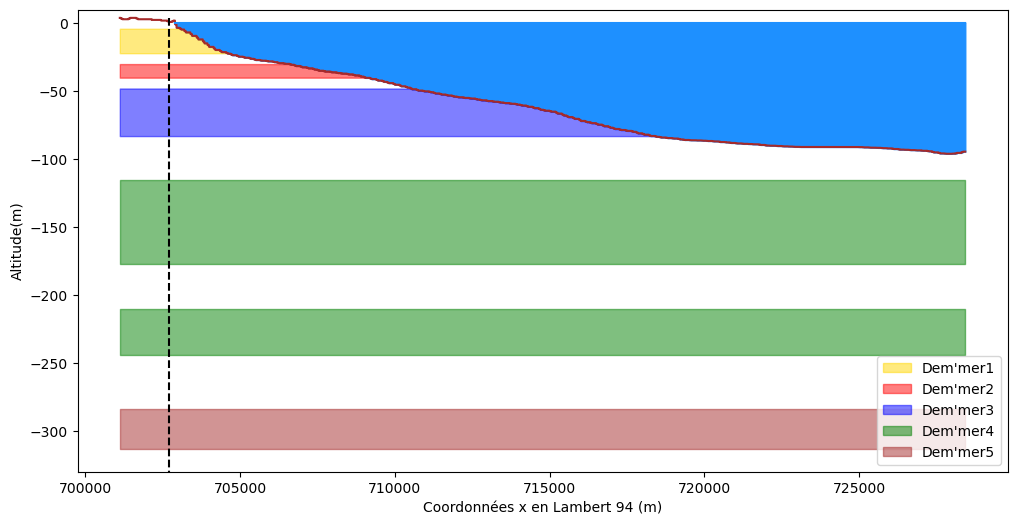

In [5]:
plt.figure(figsize=(12,6))
plt.plot(cr.geometry.x,cr.alt,color='brown')
plt.plot([702900,np.max(cr.geometry.x)],[0.59,0.59],color='dodgerblue')
plt.ylim(-330,10)
plt.plot([702705,702705],[4,-330],color='black',linestyle='dashed')

plt.fill_between(cr.geometry.x[cr.alt<0.6],cr.alt[cr.alt<0.6],np.full(len(cr.geometry.x[cr.alt<0.6]),0.6),color='dodgerblue')

dem1_top=np.full(len(cr.geometry.x[cr.alt>-22]),-4)
dem1_top2=[min(dem1_top[i],cr.alt[cr.alt>-22][i]) for i in range(len(dem1_top))]
plt.fill_between(cr.geometry.x[cr.alt>-22],np.full(len(cr.geometry.x[cr.alt>-22]),-22),dem1_top2, facecolor="gold", edgecolor="gold", linewidth=1.0,alpha=.5,label="Dem'mer1")

dem2_top=np.full(len(cr.geometry.x[cr.alt>-40]),-30)
dem2_top2=[min(dem2_top[i],cr.alt[cr.alt>-40][i]) for i in range(len(dem2_top))]
plt.fill_between(cr.geometry.x[cr.alt>-40],np.full(len(cr.geometry.x[cr.alt>-40]),-40),dem2_top2, facecolor="red", edgecolor="red", linewidth=1.0,alpha=.5,label="Dem'mer2")

dem3_top=np.full(len(cr.geometry.x[cr.alt>-83]),-48)
dem3_top2=[min(dem3_top[i],cr.alt[cr.alt>-83][i]) for i in range(len(dem3_top))]
plt.fill_between(cr.geometry.x[cr.alt>-83],np.full(len(cr.geometry.x[cr.alt>-83]),-83),dem3_top2, facecolor="blue", edgecolor="blue", linewidth=1.0,alpha=.5,label="Dem'mer3")

plt.fill_between([np.min(cr.geometry.x),np.max(cr.geometry.x)],[-115,-115],[-177,-177], facecolor="green", edgecolor="green", linewidth=1.0,alpha=.5,label="Dem'mer4")
plt.fill_between([np.min(cr.geometry.x),np.max(cr.geometry.x)],[-210,-210],[-244,-244], facecolor="green", edgecolor="green", linewidth=1.0,alpha=.5)
plt.fill_between([np.min(cr.geometry.x),np.max(cr.geometry.x)],[-284,-284],[-313,-313], facecolor="brown", edgecolor="brown", linewidth=1.0,alpha=.5,label="Dem'mer5")
plt.ylabel('Altitude(m)')
plt.xlabel('Coordonnées x en Lambert 94 (m)')
plt.legend()

In [6]:
import imageio.v3 as iio
im = iio.imread('../data/cross_section/Facies.png')

In [7]:
xs=np.arange(0,np.shape(im)[1]).astype('float')
ys=np.arange(0,np.shape(im)[0]).astype('float')

#transformation:

y_right_png=4517-371
y_right_ai=177.49-72.17

scaley_ai=181.65-59.98
scaley_real=1200.

y_transfo=y_right_ai/y_right_png*scaley_real/scaley_ai

y_origin=4516 
y_shift=(72.17- 59.98)*scaley_real/scaley_ai


ys=(ys-y_origin)*y_transfo-y_shift

x_top_png=9915-11
x_top_ai=406.65-155.07

scalex_ai=394.89-15.26
scalex_real=75*1000

x_transfo=x_top_ai/x_top_png*scalex_real/scalex_ai

x_origin=9915

x_shift=(406.65- 15.26)*scalex_real/scalex_ai


xs=(xs-x_origin)*x_transfo+x_shift

ys=ys[::-1]


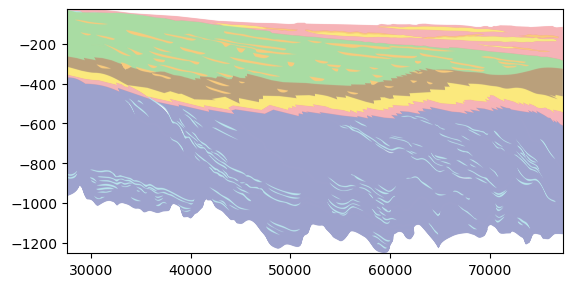

In [8]:
plt.figure()
plt.imshow(im,extent=[np.min(xs),np.max(xs),np.min(ys),np.max(ys)],aspect='20')

In [9]:
gray = cv2.cvtColor(im[:,:,:-1], cv2.COLOR_BGR2GRAY)

c1=136
c2=159
c3=83
c4=169
c4_=172
c5=121
c6,c6_=35,38
c7=206



fac=np.full(np.shape(im)[:-1],np.nan)
fac[gray==c1]=1
fac[gray==c2]=2
fac[gray==c3]=3
fac[gray==c4]=4
fac[gray==c4_]=4
fac[gray==c5]=5
fac[gray==c6]=6
fac[gray==c6_]=6
fac[gray==c7]=7

for i in range(1,8):
    fac=remove_cell_iso(fac,i,min_size=10)


flat=pd.Series(fac.flatten())
flat2=flat.fillna(method='ffill')
res=np.reshape(flat2.values,np.shape(fac))

res[gray==255]=np.nan

geol_mer=res.copy()

C:\Users\rycvo\AppData\Local\Temp\ipykernel_25524\4017543123.py:30: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  flat2=flat.fillna(method='ffill')


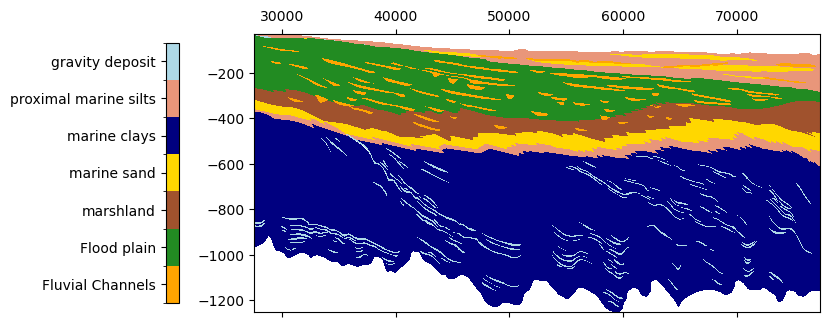

In [10]:
%matplotlib inline
coupe=plt.matshow(geol_mer,cmap=cmap, norm=norm,extent=[np.min(xs),np.max(xs),np.min(ys),np.max(ys)],aspect='20')
cbar=plt.colorbar(coupe,location='left',ticks=[1,2,3,4,5,6,7],shrink=.7)
cbar.ax.set_yticklabels(['Fluvial Channels','Flood plain','marshland','marine sand','marine clays','proximal marine silts','gravity deposit']);

# Coupe Terre

In [11]:
im2 = iio.imread('../data/cross_section/Fichier 11.png')

In [12]:
xs2=np.arange(0,np.shape(im2)[1]).astype('float')
ys2=np.arange(0,np.shape(im2)[0]).astype('float')

#transformation:

y_left_png=2630-2106
y_left_ai=60.41-47.1275 #0-haut à gauche 

scaley_ai=181.65-59.98
scaley_real=1200.

y_transfo=y_right_ai/y_right_png*scaley_real/scaley_ai

y_origin=2630
y_shift=(59.98-47.1275)*scaley_real/scaley_ai


ys2=(ys2-y_origin)*y_transfo+y_shift

x_top_png=4823-8
x_top_ai=137.57-15.21 #droite-gauche
#Left side alined to 0
scalex_ai=394.89-15.26
scalex_real=75*1000

x_transfo=x_top_ai/x_top_png*scalex_real/scalex_ai

x_origin=9

x_shift=0


xs2=(xs2-x_origin)*x_transfo+x_shift

ys2=ys2[::-1]


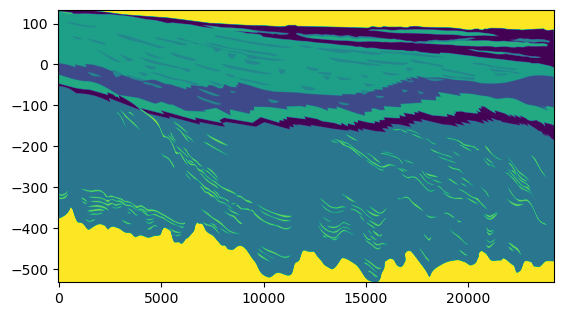

In [14]:
%matplotlib inline
plt.figure()
# xs2=np.arange(0,np.shape(im2)[1]).astype('float')
# ys2=np.arange(0,np.shape(im2)[0]).astype('float')
plt.imshow(gray,extent=[np.min(xs2),np.max(xs2),np.min(ys2),np.max(ys2)],aspect='20')

In [15]:
gray = cv2.cvtColor(im2[:,:,:-1], cv2.COLOR_BGR2GRAY)

c1=135
c2=120
c3=69
c4=188
c5=154

fac=np.full(np.shape(im2)[:-1],np.nan)
fac[gray==c1]=1
fac[gray==c2]=2
fac[gray==c3]=3
fac[gray==c4]=4
fac[gray==c5]=5


for i in range(1,6):
    fac=remove_cell_iso(fac,i,min_size=10)


flat=pd.Series(fac.flatten())
flat2=flat.fillna(method='ffill')
res=np.reshape(flat2.values,np.shape(fac))
res[gray==255]=np.nan


geol_terre=res.copy()

C:\Users\rycvo\AppData\Local\Temp\ipykernel_25524\2181799174.py:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  flat2=flat.fillna(method='ffill')


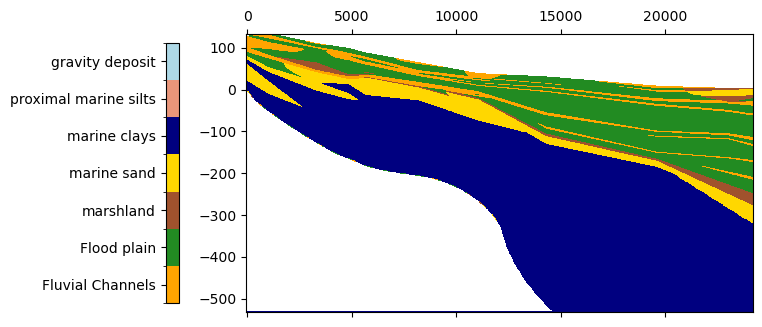

In [16]:
%matplotlib inline
coupe=plt.matshow(geol_terre,cmap=cmap, norm=norm,extent=[np.min(xs2),np.max(xs2),np.min(ys2),np.max(ys2)],aspect='20')
cbar=plt.colorbar(coupe,location='left',ticks=[1,2,3,4,5,6,7],shrink=.7)
cbar.ax.set_yticklabels(['Fluvial Channels','Flood plain','marshland','marine sand','marine clays','proximal marine silts','gravity deposit']);

# Jonction

In [17]:
im3 = iio.imread('../data/cross_section/Fichier 15.png')

xs2=np.arange(0,np.shape(im2)[1]).astype('float')
ys2=np.arange(0,np.shape(im2)[0]).astype('float')

#transformation:

y_left_png=2630-2106
y_left_ai=60.41-47.1275 #0-haut à gauche 

scaley_ai=181.65-59.98
scaley_real=1200.

y_transfo=y_right_ai/y_right_png*scaley_real/scaley_ai

y_origin=2630
y_shift=(59.98-47.1275)*scaley_real/scaley_ai


ys2=(ys2-y_origin)*y_transfo+y_shift

x_top_png=4823-8
x_top_ai=137.57-15.21 #droite-gauche
#Left side alined to 0
scalex_ai=394.89-15.26
scalex_real=75*1000

x_transfo=x_top_ai/x_top_png*scalex_real/scalex_ai

x_origin=9

x_shift=0


xs2=(xs2-x_origin)*x_transfo+x_shift

ys2=ys2[::-1]

X,Y=np.meshgrid(xs2,ys2)

In [18]:
xs3=np.arange(0,np.shape(im3)[1]).astype('float')
ys3=np.arange(0,np.shape(im3)[0]).astype('float')



J1x=3
J2x=694

J1x_=24178.4
J2x_=27610.935

J1y=57
J2y=1289

J1y_=-14.3
J2y_=-320

scalex=(J2x_-J1x_)/(J2x-J1x)
scaley=(J2y_-J1y_)/(J2y-J1y)

xs3=(xs3-J1x)*scalex+J1x_
ys3=(ys3-J1y)*scaley+J1y_



In [19]:
gray = cv2.cvtColor(im3[:,:,:-1], cv2.COLOR_BGR2GRAY)

c1=135
c2=120
c3=69
c4=188
c5=154
c6=35
c6_=111

fac=np.full(np.shape(im3)[:-1],np.nan)
fac[gray==c1]=1
fac[gray==c2]=2
fac[gray==c3]=3
fac[gray==c4]=4
fac[gray==c5]=5
fac[gray==c6]=6
fac[gray==c6_]=6


for i in range(1,7):
    fac=remove_cell_iso(fac,i,min_size=100)


flat=pd.Series(fac.flatten())
flat2=flat.interpolate(method='nearest')
res=np.reshape(flat2.values,np.shape(fac))

res[:,:70][res[:,:70]==6]=1

res[gray==255]=np.nan

def droite_2(x,y):
    if 43/673*x+92<y:
        return True

x2=np.arange(0,np.shape(im3)[1]).astype('float')
y2=np.arange(0,np.shape(im3)[0]).astype('float') 

mask=np.full(np.shape(im3)[:-1],False)
for i in range(len(mask)):
    for j in range(len(mask[0])):
        if droite_2(x2[j],y2[i]):
            mask[i,j]=True


res2=res.copy()
res2[np.isnan(res2)*mask]=2
res2[:,:3]=np.nan
res2[:,-3:]=np.nan
res2[2127:,:]=np.nan

for i in range(1,7):
    res2=remove_cell_iso(res2,i,min_size=100)


flat=pd.Series(res2.flatten())
flat2=flat.interpolate(method='nearest')
res3=np.reshape(flat2.values,np.shape(res2))

for i in range(1,7):
    res3=remove_cell_iso(res3,i,min_size=10)

flat=pd.Series(res3.flatten())
flat2=flat.interpolate(method='nearest')
res4=np.reshape(flat2.values,np.shape(res3))    
    
    
def droite_nan(x,y):
    if 108/643*x+22-432/643>y:
        return True

xnan=np.arange(0,np.shape(im3)[1]).astype('float')
ynan=np.arange(0,np.shape(im3)[0]).astype('float') 

mask=np.full(np.shape(im3)[:-1],False)
for i in range(len(mask)):
    for j in range(len(mask[0])):
        if droite_nan(xnan[j],ynan[i]):
            mask[i,j]=True
            
geol_jonction=res3.copy()
geol_jonction[:,5:][mask[:,5:]*np.isnan(res)[:,5:]]=np.nan
geol_jonction[94:117,0:4]=2

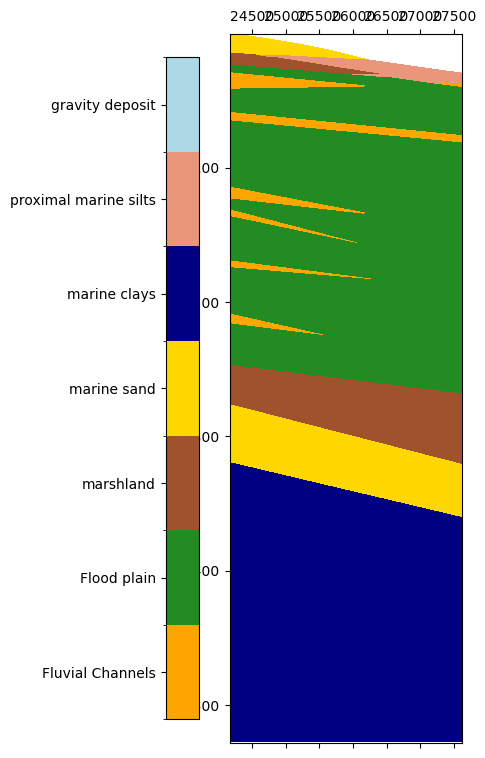

In [21]:
%matplotlib inline
coupe=plt.matshow(geol_jonction,cmap=cmap, norm=norm,extent=[np.min(xs3),np.max(xs3),np.min(ys3),np.max(ys3)],aspect='20')
cbar=plt.colorbar(coupe,location='left',ticks=[1,2,3,4,5,6,7],shrink=.7)
cbar.ax.set_yticklabels(['Fluvial Channels','Flood plain','marshland','marine sand','marine clays','proximal marine silts','gravity deposit']);

[Text(0, 1, 'Fluvial Channels'),
 Text(0, 2, 'Flood plain'),
 Text(0, 3, 'marshland'),
 Text(0, 4, 'marine sand'),
 Text(0, 5, 'marine clays'),
 Text(0, 6, 'proximal marine silts'),
 Text(0, 7, 'gravity deposit')]

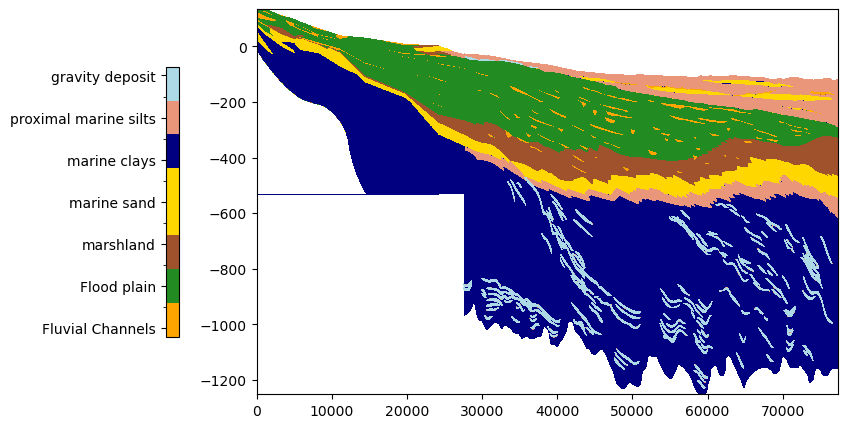

In [24]:
%matplotlib inline
fig,ax=plt.subplots(1,1,figsize=(10,5))

coupe=ax.contourf(xs2,ys2,geol_terre,cmap=cmap, norm=norm)
coupe2=ax.contourf(xs,ys,geol_mer,cmap=cmap, norm=norm)
coupe3=ax.contourf(xs3,ys3,geol_jonction,cmap=cmap, norm=norm)
cbar=plt.colorbar(coupe2,location='left',ticks=[1,2,3,4,5,6,7],shrink=.7)
cbar.ax.set_yticklabels(['Fluvial Channels','Flood plain','marshland','marine sand','marine clays','proximal marine silts','gravity deposit'])
#plt.savefig('coupe_regroupee.png',dpi=300,bbox_inches='tight')

# Save as tif

In [25]:
import rasterio
from rasterio.transform import Affine

In [26]:
x,y=xs3,ys3
X,Y=np.meshgrid(x,y)
Z=geol_jonction

In [27]:
xres = (x[-1] - x[0]) / len(x)
yres = (y[-1] - y[0]) / len(y)

transform = Affine.translation(x[0] - xres / 2, y[0] - yres / 2) * Affine.scale(xres, yres)

with rasterio.open(
        "../data/cross_section/geol_jonction.tif",
        mode="w",
        driver="GTiff",
        height=Z.shape[0],
        width=Z.shape[1],
        count=1,
        dtype=Z.dtype,
        transform=transform,
) as new_dataset:
        new_dataset.write(Z, 1)

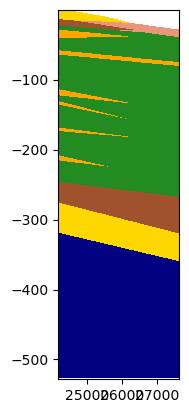

In [28]:
raster = rasterio.open("../data/cross_section/geol_jonction.tif")

plt.imshow(raster.read(1), cmap=cmap, norm=norm,interpolation='none',extent=[raster.bounds[0],raster.bounds[2],raster.bounds[1],raster.bounds[3]],aspect='20')
plt.show()

In [29]:
from rasterio.merge import merge

files_to_mosaic = [ "../data/cross_section/geol_jonction.tif",  "../data/cross_section/geol_terre.tif", "../data/cross_section/geol_mer.tif"] # However many you want.

mosaic, output=merge(files_to_mosaic, method = 'first',nodata=np.nan)




output_meta = raster.meta.copy()
output_meta.update(
    {"driver": "GTiff",
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": output,
    }
)


with rasterio.open("../data/cross_section/geol_complete.tif", "w",**output_meta) as m:
    m.write(mosaic)

In [30]:
demmerx=24100
demmerx_real=702705
transfo=demmerx_real-demmerx

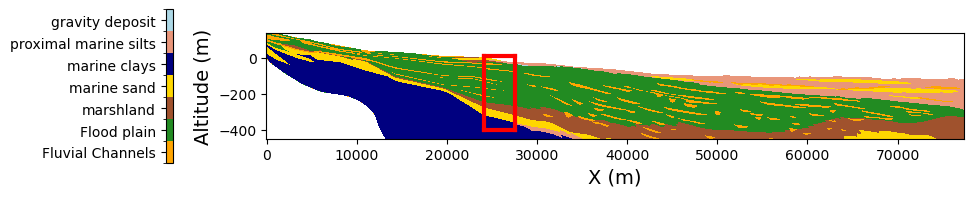

In [31]:
%matplotlib inline
raster = rasterio.open("../data/cross_section/geol_complete.tif")
fig,ax=plt.subplots(1,1,figsize=(12,4))
ax.plot([24100,24100],[-400,10],color='red',linewidth=3)
ax.plot([27500,27500],[-400,10],color='red',linewidth=3)
ax.plot([24100,27500],[-400,-400],color='red',linewidth=3)
ax.plot([24100,27500],[10,10],color='red',linewidth=3)
coupe=ax.imshow(raster.read(1), cmap=cmap, norm=norm,interpolation='none',extent=[raster.bounds[0],raster.bounds[2],raster.bounds[1],raster.bounds[3]],aspect='20')
cbar=plt.colorbar(coupe,location='left',ticks=[1,2,3,4,5,6,7],shrink=.5)
cbar.ax.set_yticklabels(['Fluvial Channels','Flood plain','marshland','marine sand','marine clays','proximal marine silts','gravity deposit'])
plt.xlabel("X (m)",fontsize=14)
plt.ylabel("Altitude (m)",fontsize=14)
plt.ylim(-450)
plt.savefig('../Figs/cross_section_legende.png',dpi=300,bbox_inches='tight')